In [1]:
import tensorflow as tf
import numpy as np
import cv2

import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

In [2]:
from layers import conv_layer, max_pool_2x2, full_layer

MINIBATCH_SIZE = 50
STEPS = 10000

home = os.getcwd().split('AUT-CNN-TUB')[0]
test_path  = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_merge_28/test/')
train_path = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_merge_28/train/')
validate_path = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_Validation_28/train/')

model_path  = os.path.join(home,'AUT-CNN-TUB', 
                           'Data',
                           'Models',
                           'aws_28',
                           '/home/jeronimo/git/AUT-CNN-TUB/Data/Models/aws_28/model_merge_28_b50_s10000_2018-8-29_18-57.ckpt')


labels = ['01.0', '02.0', '03.0', '04.0', '05.0', '06.0', '07.1', '07.2',
         '08.0', '09.0','10.0','11.0', '12.0','13.0','14.0', '15.0']
position_dict = {k: v for v, k in enumerate(labels)}
label_dict = {v : k  for v, k in enumerate(labels)}

def label_to_binary(position_dict, label):
    z = np.zeros(len(position_dict), dtype=int)
    z[position_dict[label]] = 1 
    return z

def next_batch(path, size, GRBtoGray=False, flatten=False):
    
    data_path = os.path.join(path, '*g')  # ???
    files = glob.glob(data_path)
    num_imag = len(files)
    Data = np.arange(0, num_imag)
    batchindices = np.random.choice(Data, size=size,
                                    replace=False)  # Zufallsstichprobe; reihenfolge beliebig; ohne zurückl.

    label_list =[]
    img_list = []
    for i, file_path in enumerate(files):
        if i in batchindices:
            label_str = file_path.split('/')[-1][:4]
            label_bin = label_to_binary(position_dict, label_str)

            if GRBtoGray == True:
                img = cv2.imread(file_path, flags=0)
            else:
                img = cv2.imread(file_path, flags=1)

            if flatten == True:
                img_list.append(img.flatten())
                label_list.append(label_bin)
            else:
                img_list.append(img)
                label_list.append(label_bin)

    img_list = np.array(img_list)
    label_list = np.array(label_list)


    return img_list, label_list




class DataGetter:
    def __init__(self, path, GRBtoGray=False, flatten=False): 
        self.path  = path
        self.GRBtoGray  = GRBtoGray
        self.flatten  = flatten
        self.batchindices = None
        
        self.data_path = os.path.join(self.path, '*g') 
        self.files = glob.glob(self.data_path)
        self.num_imag = len(self.files)
        self.Data = list(range(0, self.num_imag))

    def get_batch(self,size):
        
        if len(self.Data) > size:
            self.batchindices = list(np.random.choice(self.Data, size=size, replace=False))
            for x in self.batchindices:
                self.Data.remove(x) 
                
        elif len(self.Data) == size:
            self.batchindices = np.random.choice(self.Data, size=size, replace=False)  
            self.Data = list(range(0, self.num_imag))

            
        else:
            self.batchindices = np.random.choice(self.Data, size=len(self.Data), replace=False)  
            self.Data = list(range(0, self.num_imag))



            

        label_list =[]
        img_list = []
        file_name_list = []
        for i, file_path in enumerate(self.files):
            if i in self.batchindices:
                label_str = file_path.split('/')[-1][:4]
                label_bin = label_to_binary(position_dict, label_str)

                if self.GRBtoGray == True:
                    img = cv2.imread(file_path, flags=0)
                else:
                    img = cv2.imread(file_path, flags=1)

                if self.flatten == True:
                    img_list.append(img.flatten())
                    label_list.append(label_bin)
                    file_name_list.append(file_path.split('/')[-1])
                else:
                    img_list.append(img)
                    label_list.append(label_bin)
                    file_name_list.append(file_path.split('/')[-1])

        img_list = np.array(img_list)
        label_list = np.array(label_list)


        return img_list, label_list, file_name_list
    
test_img = DataGetter(test_path, False, False)
train_img = DataGetter(train_path, False, False)

In [3]:
model_path

'/home/jeronimo/git/AUT-CNN-TUB/Data/Models/aws_28/model_merge_28_b50_s10000_2018-8-29_18-57.ckpt'

In [4]:
tf.reset_default_graph()
# Create some variables.

x = tf.placeholder(tf.float32, shape=[None, 28, 28, 3])
y_ = tf.placeholder(tf.float32, shape=[None, len(position_dict)])

#x_image = tf.reshape(x, [-1, 28, 28, 1])
conv1 = conv_layer(x, shape=[5, 5, 3, 64])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 64, 128])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*128])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, len(position_dict))

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Add ops to save and restore only `v2` using the name "v2"
saver = tf.train.Saver()


# Use the saver object normally after that.
with tf.Session() as sess:
    # Initialize v1 since the saver will not.
    #v1.initializer.run()
    saver.restore(sess, model_path)

    X_batch, y_batch, file_name = test_img.get_batch(2000)#len(os.listdir(test_path)))

    test_accuracy = sess.run(accuracy, feed_dict={x: X_batch, y_: y_batch, keep_prob: 1.0})
    cross_entro = sess.run(cross_entropy, feed_dict={x: X_batch, y_: y_batch, keep_prob: 1.0})

    print("test accuracy: {}".format(test_accuracy))
    print("cross entropy: {}".format(cross_entro))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

INFO:tensorflow:Restoring parameters from /home/jeronimo/git/AUT-CNN-TUB/Data/Models/aws_28/model_merge_28_b50_s10000_2018-8-29_18-57.ckpt
test accuracy: 0.9940000176429749
cross entropy: 0.18310534954071045


INFO:tensorflow:Restoring parameters from /home/jeronimo/git/AUT-CNN-TUB/Data/Models/aws_28/model_merge_28_b50_s10000_2018-8-29_18-57.ckpt
13.0 ['07.2.0.2.0260.jpg']
[[  -5.565493  -25.255583  -18.192284  -65.30483  -133.22604    73.82794
    14.22658   380.5885   -112.36124  -204.60544  -295.59506    19.297283
   184.57507   457.7149     68.01957  -168.85396 ]]


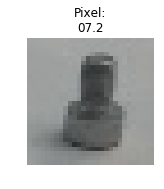

13.0 ['12.0.0.1.0170.jpg']
[[ 5.4198813e+00  3.5183140e+01 -3.0907083e+02  1.0158702e+02
  -3.9494571e+02  2.8700924e+01 -1.1370860e-02  3.7494968e+02
  -1.4530966e+02 -1.3707973e+02 -5.2290350e+02  1.6305878e+02
   6.0854596e+02  6.2229510e+02  3.9432987e+01 -1.1146184e+02]]


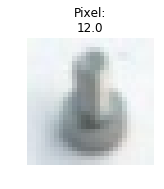

13.0 ['15.0.0.0.0141.jpg']
[[ 102.137535 -149.56104  -380.4324    -90.92772  -225.59412     5.09658
   103.14257   -25.549091   37.373135  137.84723  -354.1567    131.84825
    41.597733  452.73438    84.29878   389.45377 ]]


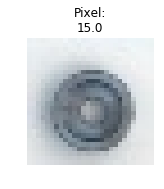

13.0 ['12.0.0.0.0093.jpg']
[[ -84.754524    -6.7601147 -371.75894     -1.4272324 -252.5583
   -82.52965     39.875942   237.43674   -143.27681   -146.98566
  -428.85522     85.071396   350.54996    380.5278      65.82345
    84.21541  ]]


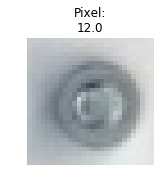

In [ ]:
tf.reset_default_graph()
# Create some variables.
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 3])
y_ = tf.placeholder(tf.float32, shape=[None, len(position_dict)])

#x_image = tf.reshape(x, [-1, 28, 28, 1])
conv1 = conv_layer(x, shape=[5, 5, 3, 64])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 64, 128])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*128])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, len(position_dict))

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# Add ops to save and restore only `v2` using the name "v2"
saver = tf.train.Saver()


# Use the saver object normally after that.
with tf.Session() as sess:
    saver.restore(sess, model_path)

    X_batch, y_batch, file_name = test_img.get_batch(10)
    test_accuracy = np.mean([sess.run(accuracy, feed_dict={x: X_batch, y_: y_batch, keep_prob: 1.0})])

    print("test accuracy: {}".format(test_accuracy))
    
    for i in range(len(os.listdir(test_path))):

        X_batch, y_batch, file_name = test_img.get_batch(1)

        label = y_batch
        image_ar = X_batch[0]
        if label_dict[np.argmax(sess.run(tf.nn.softmax(y_conv, 1),
                                         feed_dict={x: X_batch,
                                                    y_: y_batch, 
                                                    keep_prob: 1}))] != label_dict[np.argmax(label)]:
            
            print(label_dict[np.argmax(sess.run(
                tf.nn.softmax(y_conv, 1), 
                feed_dict={x: X_batch, y_: y_batch, keep_prob: 1}))], file_name)
            print(sess.run(tf.cast(y_conv, 1), feed_dict={x: X_batch, y_: y_batch, keep_prob: 1}))




            fig = plt.figure(figsize=(5,5))
            ax1 = fig.add_subplot(1, 2, 1)
            ax1.axis('off')
            ax1.set_title('Pixel:\n' + label_dict[np.argmax(label)])
            ax1.imshow(image_ar);
            plt.show()

In [21]:
print(round(len(os.listdir(test_path)) * (1 - 0.9950000047683716)),
      'Fehler bei' ,
      len(os.listdir(test_path)), 
      'Testbildern')

28 Fehler bei 5521 Testbildern


In [86]:
tf.reset_default_graph()
# Create some variables.
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 3])
y_ = tf.placeholder(tf.float32, shape=[None, len(position_dict)])

#x_image = tf.reshape(x, [-1, 28, 28, 1])
conv1 = conv_layer(x, shape=[5, 5, 3, 64])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 64, 128])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*128])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, len(position_dict))

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# Add ops to save and restore only `v2` using the name "v2"
saver = tf.train.Saver()


# Use the saver object normally after that.
with tf.Session() as sess:
    saver.restore(sess, model_path)

    for num in ['1','2','3','4','5','6','7.1','7.2','8','9','10','11','13','14','15']:
        predict =  []

        #print((sess.run(tf.nn.softmax(y_conv, 1), 
         #                  feed_dict={x: img_list_array,  keep_prob: 1})))
        files = os.listdir(os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_canon_centered_28x28/{}/'.format(num)))
        print(num)
        for f in files:
            img = cv2.imread(os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_canon_centered_28x28/{}/'.format(num), f), flags=1)

            predict.append(label_dict[np.argmax(sess.run(
                        tf.nn.softmax(y_conv, 1), 
                        feed_dict={x: np.array([img]),  keep_prob: 1}))])

        hist = pd.Series(predict)
        print(hist.value_counts())

    print('fertig')

INFO:tensorflow:Restoring parameters from /home/jeronimo/git/AUT-CNN-TUB/Data/Models/aws_28/model_merge_28_b50_s10000_2018-8-29_18-57.ckpt
1
01.0    194
03.0      1
dtype: int64
2
02.0    143
dtype: int64
3
03.0    110
01.0      2
dtype: int64
4
04.0    117
05.0      1
dtype: int64
5
05.0    97
04.0     7
dtype: int64
6
06.0    52
dtype: int64
7.1
07.1    127
08.0      5
13.0      1
01.0      1
dtype: int64
7.2
07.2    109
13.0      8
12.0      4
10.0      1
dtype: int64
8
08.0    141
13.0      1
15.0      1
dtype: int64
9
09.0    147
10.0      1
dtype: int64
10
10.0    139
09.0      9
dtype: int64
11
11.0    154
03.0      1
dtype: int64
13
13.0    153
07.2      1
dtype: int64
14
14.0    166
dtype: int64
15
15.0    164
dtype: int64
fertig
